# AdaBoost by scratch

In [204]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from functools import reduce

In [221]:
data = pd.read_csv('train.csv', usecols = ['Survived', 'Pclass', 'Age', 
                                           'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked'])
data['Embarked'] = data['Embarked'].fillna(value = 'Q')

sex_ohe = OneHotEncoder()
bark_ohe = OneHotEncoder()
X = sex_ohe.fit_transform(data['Sex'].values.reshape(-1,1)).toarray()
Xm = bark_ohe.fit_transform(data['Embarked'].values.reshape(-1,1)).toarray()

dfOneHot = pd.DataFrame(X, columns = ["Sex_"+str(int(i)) for i in range(X.shape[1])])
data = pd.concat([data, dfOneHot], axis=1)

dfOneHot = pd.DataFrame(Xm, columns = ["Embark"+str(int(i)) for i in range(Xm.shape[1])])
data = pd.concat([data, dfOneHot], axis=1)

data = data.drop(['Sex', 'Embarked'], axis = 1)
data['weight'] = 1 / data.shape[0]

In [234]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [244]:
data['Fare'] = data['Fare'] / 10

In [162]:
def borders(vals):
    values = sorted(list(set(vals)))
    border = list(set([(a + b) / 2 for a, b in zip(values[::1], values[1::1])]))
    return border

In [269]:
def partition(data, label_col, algo = 'reg'):
    
    # Answer list
    part = []
    
    # Regression partition
    if algo == 'reg':
        
        # Initial variety
        mean_0 = np.mean(data[label_col].values)
        d0 = sum(list(map(lambda x: (x - mean_0) ** 2, data[label_col])))
        
        # Individual variety calculation
        for col in data.columns:
            if col != label_col:
                
                # Calculating partition borders for current column
                border = borders(data[col].values)
                
                # Calculating variety for both ends of partition for current partition border
                for edge in border:
                    low_data = data[data[col] < edge]
                    high_data = data[data[col] > edge]
                    mean_low = np.mean(low_data[label_col].values)
                    d1 = sum(list(map(lambda x: (x - mean_low) ** 2, low_data[label_col])))
                    mean_high = np.mean(high_data[label_col].values)
                    d2 = sum(list(map(lambda x: (x - mean_high) ** 2, high_data[label_col])))
                    part.append([d0 - (low_data.shape[0] * d1 / data.shape[0]) - (high_data.shape[0] * d2 / data.shape[0]), col, edge])
    
    # Classification partition
    if algo == 'clf':
        
        # Initial entropy
        p0_1 = data[label_col].sum() / data.shape[0]
        p0_2 = 1 - p0_1
        S0 = - p0_1 * np.log(p0_1) - p0_2 * np.log(p0_2)
        
        # Individual variety calculation
        for col in data.columns:
            if col != label_col:
                
                # Calculating partition borders for current column
                border = borders(data[col].values)
                
                # Calculating variety for both ends of partition for current partition border
                for edge in border:
                    
                    # Entropy for data under edge
                    low_data = data[data[col] < edge]
                    p1_1 = low_data[label_col].sum() / low_data.shape[0]
                    p1_2 = 1 - p1_1
                    if (p1_1 == 0) | (p1_2 == 0):
                        S1 = 0
                    else:
                        S1 = - p1_1 * np.log(p1_1) - p1_2 * np.log(p1_2)
                    
                    # Entropy for data over edge
                    high_data = data[data[col] > edge]
                    p2_1 = high_data[label_col].sum() / high_data.shape[0]
                    p2_2 = 1 - p2_1
                    if (p2_1 == 0) | (p2_2 == 0):
                        S2 = 0
                    else:
                        S2 = - p2_1 * np.log(p2_1) - p2_2 * np.log(p2_2)
                        
                    side = 'low' if p1_1 > p2_1 else 'high'
                    
                    ent_loss = S0 - (low_data.shape[0]*S1/data.shape[0]) - (high_data.shape[0]*S2/data.shape[0])
                    
                    part.append([ent_loss, col, edge, side])
    
    else:
        print('Wrong algorithm type')
        return
    
    part.sort(reverse = True)
    
    return part[0][1], part[0][2], part[0][3]

In [243]:
# Calculating number of errors for predictions

def amount_of_say(data, label_col):
    
    part_col, part_edge, part_side = partition(data, label_col, 'clf')

    predictions = []
    total_error = 0.00001
    error_index = []
    for i in range(data.shape[0]):
        if part_side == 'low':
            if (data.iloc[i][part_col] < part_edge) & (data.iloc[i][label_col] == 0):
                total_error += data.iloc[i]['weight']
                error_index.append(i)
            elif (data.iloc[i][part_col] > part_edge) & (data.iloc[i][label_col] == 1):
                total_error += data.iloc[i]['weight']
                error_index.append(i)
        elif part_side == 'high':
            if (data.iloc[i][part_col] > part_edge) & (data.iloc[i][label_col] == 0):
                total_error += data.iloc[i]['weight']
                error_index.append(i)
            elif (data.iloc[i][part_col] < part_edge) & (data.iloc[i][label_col] == 1):
                total_error += data.iloc[i]['weight']
                error_index.append(i)
                
    aos = 0.5 * np.log((1 - total_error) / total_error)
                    
    return aos, error_index, part_col, part_edge, part_side

In [174]:
# Update weights

def new_dataset(data, label_col):
    
    aos, error_index, part_col, part_edge, part_side = amount_of_say(data, label_col)
    
    new_weights = []
    
    for i in range(data.shape[0]):
        if i in error_index:
            new_weights.append(data.iloc[i]['weight'] * np.exp(aos))
        else:
            new_weights.append(data.iloc[i]['weight'] * np.exp(-aos))

    data.loc[:, 'weight'] = new_weights
    data.loc[:, 'weight'] = data.loc[:, 'weight'] / sum(new_weights)
    
    new_set = pd.DataFrame()
    
    intervals = [data.iloc[0]['weight']]
    
    for i in range(1, data.shape[0]):
        intervals.append(intervals[i - 1] + data.iloc[i]['weight'])
    
    for i in range(data.shape[0]):
        k = np.random.random()
        if k < intervals[0]:
            new_set = new_set.append(data.iloc[0])
        else:
            for j in range(1, len(intervals)):
                if k < intervals[j]:
                    new_set = new_set.append(data.iloc[j])
                    break
                    
    new_set['weight'] = 1 / new_set.shape[0]
    
    new_set = new_set.reset_index(drop = True)
    
    tree = [part_col, part_edge, part_side, aos]
        
    return new_set, tree

In [195]:
def prediction(data, trees):
    
    predictions = []
    for i in range(data.shape[0]):
        positive_pred = 0
        negative_pred = 0
        for tree_col, tree_edge, tree_side, aos in trees:
            if tree_side == 'low':
                if data.iloc[i][tree_col] < tree_edge:
                    positive_pred += aos
                else:
                    negative_pred += aos
            else:
                if data.iloc[i][tree_col] > tree_edge:
                    positive_pred += aos
                else:
                    negative_pred += aos
        if positive_pred > negative_pred:
            predictions.append(1)
        else:
            predictions.append(0)
    
    return predictions

In [198]:
def fit(data, label_col, iterations = 20):

    trees = []

    current_df = data.copy()
    iterations = iterations
    for epoch in range(iterations):
        current_df, tree = new_dataset(current_df, label_col)
        trees.append(tree)
        
    return trees

In [277]:
acc = []
label_col = 'Survived'
for i in range(5, 101, 5):
    print(i, end = ' - ')
    data_fit = data.copy()
    trees = fit(data_fit, label_col, i)
    preds = prediction(data, trees)
    acc.append(accuracy_score(preds, data[label_col].values))
    #print(f"Accuracy {round(acc[-1], 5)}")

5 - 10 - 15 - 20 - 25 - 30 - 35 - 40 - 45 - 50 - 55 - 60 - 65 - 70 - 75 - 80 - 85 - 90 - 95 - 100 - 

In [278]:
acc

[0.7867564534231201,
 0.7867564534231201,
 0.7822671156004489,
 0.7407407407407407,
 0.7485970819304153,
 0.7542087542087542,
 0.77665544332211,
 0.7609427609427609,
 0.6958473625140292,
 0.6902356902356902,
 0.7351290684624018,
 0.7025813692480359,
 0.7328843995510662,
 0.7205387205387206,
 0.6857463524130191,
 0.6677890011223344,
 0.6632996632996633,
 0.6655443322109988,
 0.691358024691358,
 0.6150392817059483]

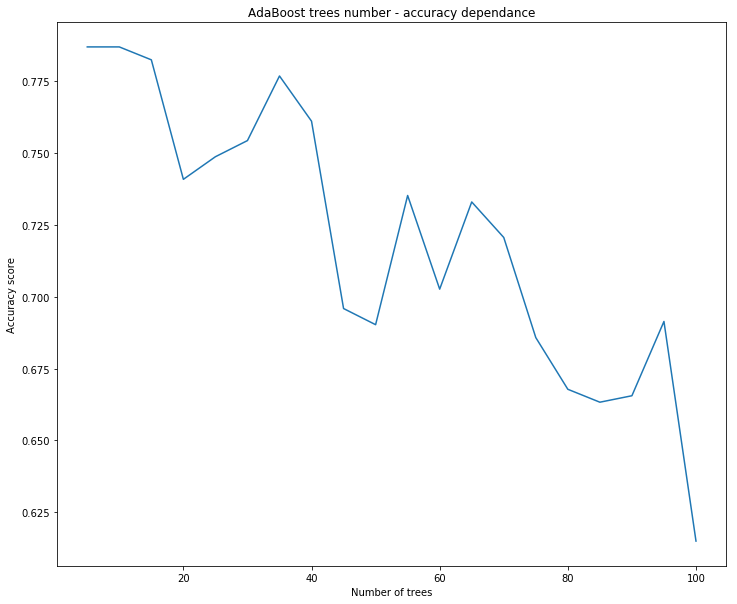

In [280]:
fig = plt.figure(figsize = (12, 10))
iters = [x for x in range(5, 101, 5)]
plt.plot(iters, acc)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('AdaBoost trees number - accuracy dependance')
plt.show()